Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [10]:
from math import sqrt
from itertools import permutations
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
class Tsp:

    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]['pos']
        pos2 = self._graph.nodes[n2]['pos']
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0])**2 +
                                                         (pos1[1] - pos2[1])**2))

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(self._graph,
                pos=nx.get_node_attributes(self._graph, 'pos'),
                with_labels=True,
                node_color='pink')
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

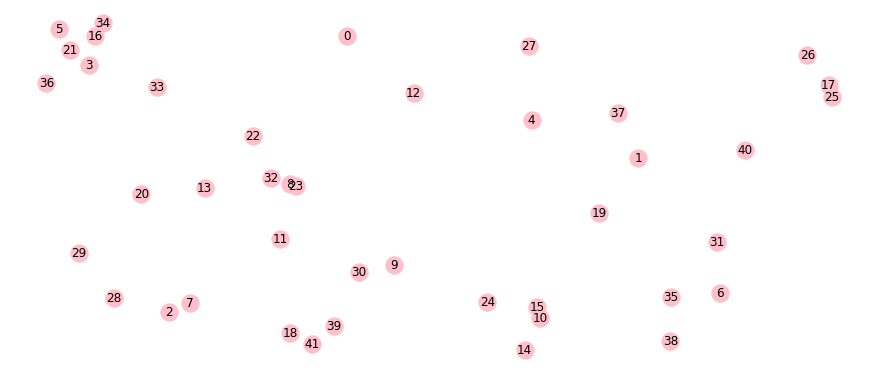

In [12]:
NUM_CITIES = 42

problem = Tsp(NUM_CITIES)
problem.plot()

## Simple Heuristic

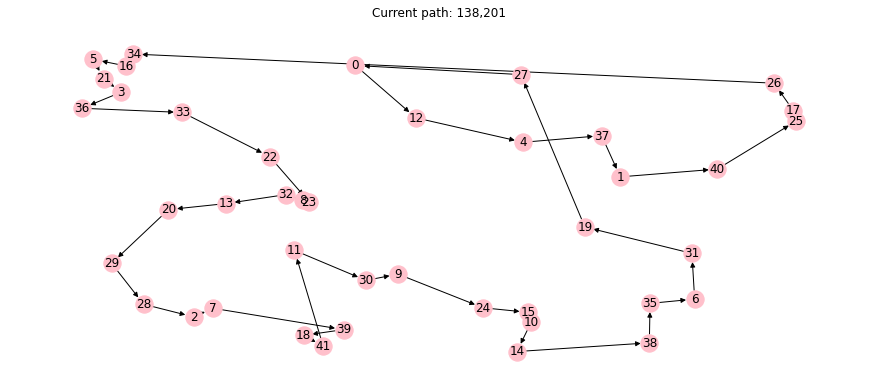

In [13]:
G = nx.Graph()
G.add_nodes_from(problem.graph.nodes())
for n1, n2, _ in sorted([(n1, n2, problem.distance(n1, n2)) for n1, n2 in permutations(problem.graph.nodes(), 2)], key=lambda t: t[2]):
    if len(G.edges(n1)) < 2 and len(G.edges(n2)) < 2:
        G.add_edge(n1, n2)
        try:
            nx.find_cycle(G)
            G.remove_edge(n1, n2)
        except:
            pass

G.add_edge(*[n for n in G if len(G.edges(n))<2])
solution = np.array([0] + [n[0] for n in nx.dfs_successors(G, 0).values()])
problem.plot(solution)

# My solutions

The Hill Climber solution is more consistent and generally less computationally expensive, therefore it can be considered the better solution between the two presented

## Random-Mutation (inversion) Hill Climber

In [14]:
# Same as the presented hill climber, but use inversion instead of swapping
def tweak(solution: np.array, *, pm: float = .5) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        new_solution[i1:i2] = np.flip(new_solution[i1:i2])
        p = np.random.random()
    return new_solution

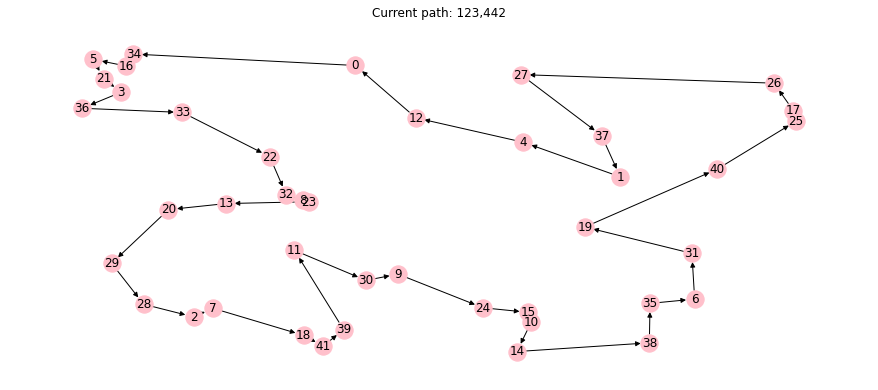

In [15]:
STEADY_STATE = 10000

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
# problem.plot(solution)

history = [(0, solution_cost)]
steady_state = 0
step = 0
while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1
    new_solution = tweak(solution)
    new_solution_cost = problem.evaluate_solution(new_solution)
    if new_solution_cost < solution_cost:
        solution = new_solution
        solution_cost = new_solution_cost
        history.append((step, solution_cost))
        steady_state = 0
problem.plot(solution)

## GA

In [16]:
MAX_GENERATIONS = 1000
POPULATION_SIZE = int(NUM_CITIES * 2 / 3)
OFFSPRING_SIZE = NUM_CITIES
MUTATION_PROBABILITY = .5
TOURNAMENT_SIZE = 2

def parent_selection(population):
    tournament = []
    for _ in range(TOURNAMENT_SIZE):
        individual = population[np.random.randint(0, len(population))]
        tournament.append(individual)
    tournament.sort(key=lambda t: t[1])
    return tournament[0][0]

def mutate(parent):
    offspring = parent.copy()
    while np.random.random() < MUTATION_PROBABILITY:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        offspring[i1:i2] = np.flip(offspring[i1:i2])
    return offspring

def xover(parent1, parent2):
    offspring = np.full(parent1.size, -1)
    i2 = np.random.randint(0, NUM_CITIES)
    i1 = np.random.randint(0, NUM_CITIES)
    if i1 > i2:
        tmp = i1
        i1 = i2
        i2 = tmp
    offspring[i1:i2] = parent1[i1:i2]
    tmp = parent2[~np.in1d(parent2, offspring)]
    offspring[:i1] = tmp[:i1]
    offspring[i2:] = tmp[i1:]
    return offspring

In [17]:
class Population:

    def __init__(self, fitness_func):
        self._population = []
        self._fitness_func = fitness_func
        for _ in range(POPULATION_SIZE):
            individual = np.array(range(NUM_CITIES))
            np.random.shuffle(individual)
            self._population.append((individual, self._fitness_func(individual)))

    def sort(self):
        self._population.sort(key=lambda t: t[1])

    def evolve(self):
        self.sort()
        # copy the fittest one with no mutations
        new_population = [self._population[0]]
        # copy the fittest half with random mutations 
        for individual, _ in self._population[1:POPULATION_SIZE//2]:
            individual = mutate(individual)
            new_population.append((individual, self._fitness_func(individual)))
        children = []
        for _ in range(OFFSPRING_SIZE):
            parent1, parent2 = parent_selection(new_population), parent_selection(new_population)
            offspring = xover(parent1, parent2)
            children.append((offspring, self._fitness_func(offspring)))
        self._population = new_population + children
        self.sort()
        self._population = self._population[:POPULATION_SIZE]

    def get_best(self):
        return self._population[0][0]

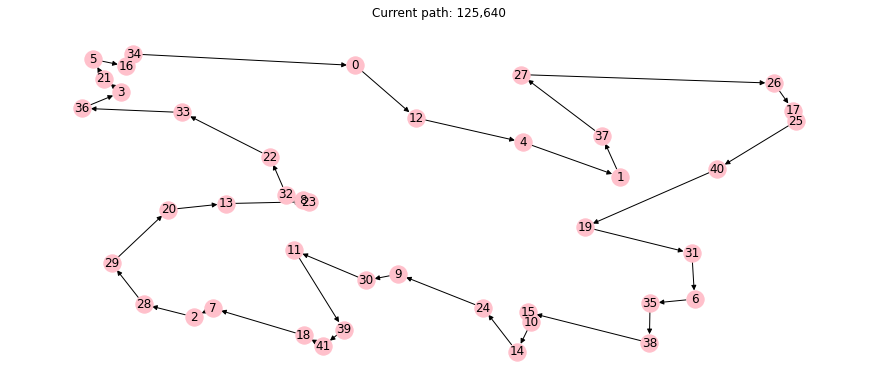

In [18]:
population = Population(problem.evaluate_solution)
for _ in range(MAX_GENERATIONS):
    population.evolve()
solution = population.get_best()
problem.plot(solution)